In [2]:
# import libraries from cnn env
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
SEED=56789
import numpy as np
np.random.seed(SEED)
import random as python_random
python_random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix, auc, average_precision_score, precision_recall_curve
import tensorflow as tf
from numpy import mean
from numpy import absolute
from numpy import std
from collections import Counter
import itertools

import shap

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('GPCR_Opt_ICHEM_FuzCav_Ligand.csv')
df.head()

,PDB_ID,poc_bit2,poc_bit4,poc_bit5,poc_bit6,poc_bit7,poc_bit9,poc_bit10,poc_bit11,poc_bit15,...,TM_7-7.43_HBond_PROT,TM_7-7.43_Hyd,TM_7-7.44_Hyd,TM_7-7.45_HBond_LIG,TM_7-7.45_Hyd,TM_7-7.46_HBond_PROT,TM_7-7.46_Hyd,TM_7-7.47_Hyd,TM_7-7.53_Hyd,Class
0,1f88,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1gzm,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1hzx,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1jfp,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1l9h,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1



Classifier Statistics for Test: 
Accuracy_Test: 0.9375
MCC_Test: 0.8719
f1_score_Test: 0.9358
ROC_AUC_Test: 0.9377820760799485
auPR_Test: 0.9072366994480914
Confusion_Matrix_Test: [[31  2]
 [ 3 44]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        33
           1       0.96      0.94      0.95        47

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



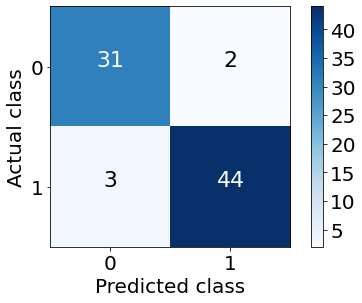

In [4]:
estimator = LogisticRegression(random_state=123, solver='liblinear')
       
X_w = df.iloc[:,0:-1]
y_w = df.iloc[:,-1]
    
X_train_w, X_test_w, y_train, y_test = train_test_split(X_w, y_w, test_size=0.2, random_state=5678, stratify=y_w)

X_train = X_train_w.iloc[:,1:-1]
X_test = X_test_w.iloc[:,1:-1]
X_train_id = X_train_w.iloc[:,0] 
X_test_id = X_test_w.iloc[:,0]   
    
model_TRTS = estimator
model_TRTS.fit(X_train, y_train)
    
y_pred_train = model_TRTS.predict(X_train)
y_pred_test = model_TRTS.predict(X_test)

y_pred_train_df = pd.DataFrame(y_pred_train, columns = ['Pred'])
y_train_df = pd.DataFrame(y_train, columns = ['Class'])
y_train_df = y_train_df.reset_index()
X_train_id = X_train_id.reset_index()
df_train_idx = pd.merge(X_train_id, y_train_df, how='inner', left_index=True, right_index=True)
df_out_train = pd.merge(df_train_idx, y_pred_train_df, how='inner', left_index=True, right_index=True)
    
y_pred_test_df = pd.DataFrame(y_pred_test, columns = ['Pred'])
y_test_df = pd.DataFrame(y_test, columns = ['Class'])
y_test_df = y_test_df.reset_index()
X_test_id = X_test_id.reset_index()
df_test_idx = pd.merge(X_test_id, y_test_df, how='inner', left_index=True, right_index=True)
df_out_test = pd.merge(df_test_idx, y_pred_test_df, how='inner', left_index=True, right_index=True)

acc_ts = accuracy_score(y_test, y_pred_test)
mcc_ts = metrics.matthews_corrcoef(y_test, y_pred_test)
f1_score_ts = metrics.f1_score(y_test, y_pred_test, average='macro')
ytests = tf.keras.utils.to_categorical(np.array(y_test), num_classes=2)
ytest_preds = tf.keras.utils.to_categorical(np.array(y_pred_test), num_classes=2)
roc_auc_ts = metrics.roc_auc_score(ytests, ytest_preds, average='macro',multi_class='ovr')

auPR_ts = average_precision_score(ytests, ytest_preds, average='macro')
cm_ts = confusion_matrix(y_test, y_pred_test)
   
print();print('Classifier Statistics for Test: ')
print("Accuracy_Test: %.4f" % acc_ts)
print("MCC_Test: %.4f" % mcc_ts)
print("f1_score_Test: %.4f" % f1_score_ts)
print("ROC_AUC_Test:", roc_auc_ts)
print("auPR_Test:", auPR_ts)
print("Confusion_Matrix_Test:", cm_ts)
print(classification_report(y_test, y_pred_test))

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    cb = plt.colorbar()
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(20)
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 fontsize=22,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual class', fontsize=20)
    plt.xlabel('Predicted class', fontsize=20)
    
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, classes = range(2))

In [5]:
pd.set_option('display.max_rows', 500)
df_out_test.head(500)

,index_x,PDB_ID,index_y,Class,Pred
0,71,4djh,71,1,1
1,61,3vg9,61,1,1
2,175,5wqc,175,1,1
3,60,3v2y,60,1,1
4,186,5ywy,186,1,0
5,53,3rze_5eh,53,1,1
6,137,5mzp,137,1,0
7,305,6rz6,305,1,1
8,15,2y00,15,0,0
9,268,6me4,268,0,0


In [6]:
pd.set_option('display.max_rows', 500)
df_out_train.head(500)

,index_x,PDB_ID,index_y,Class,Pred
0,113,5cxv,113,1,1
1,147,5olo,147,1,1
2,214,6drz,214,1,1
3,78,4iar,78,0,0
4,251,6ko5,251,1,1
5,91,4pxz,91,0,0
6,7,2g87,7,0,0
7,202,6aqf,202,1,1
8,377,7fih,377,0,0
9,141,5ndz,141,1,1


In [7]:
lr_explainer = shap.LinearExplainer(model_TRTS, X_train)
shap_values_tr = lr_explainer.shap_values(X_train)
shap_values_ts = lr_explainer.shap_values(X_test)

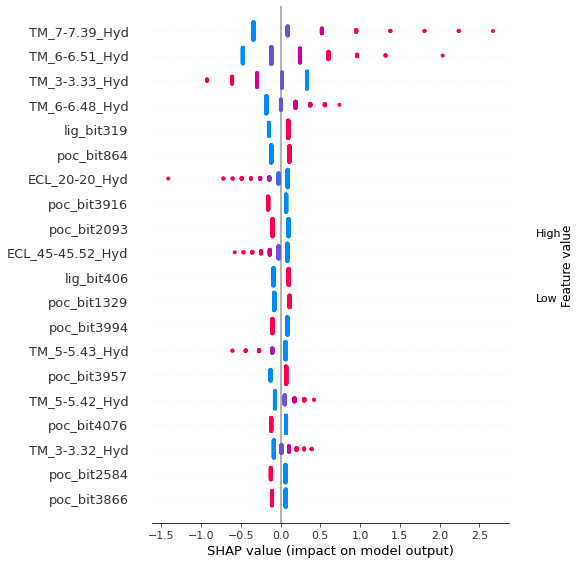

In [8]:
shap.summary_plot(shap_values_tr, X_train, show=False)
# plt.savefig('summary_plot_binary_train.jpeg', format = "jpeg", dpi = 600,bbox_inches = 'tight')

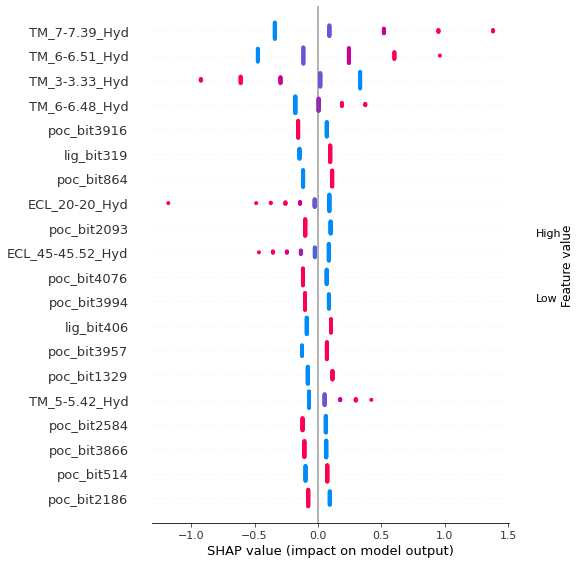

In [9]:
shap.summary_plot(shap_values_ts, X_test, show=False)
# plt.savefig('summary_plot_binary_test.jpeg', format = "jpeg", dpi = 600,bbox_inches = 'tight')

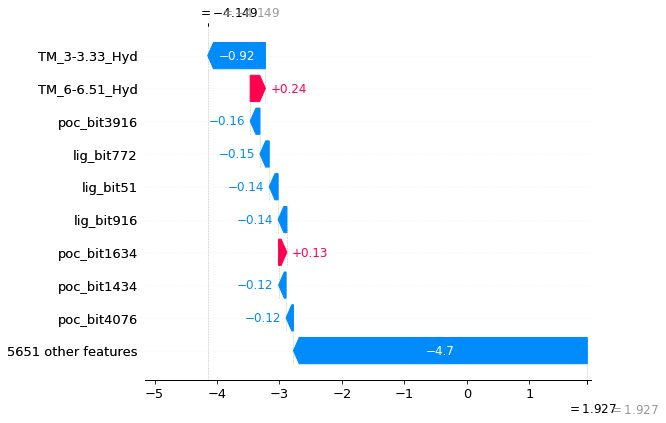

In [10]:
shap.plots._waterfall.waterfall_legacy(lr_explainer.expected_value, shap_values_ts[65], show=False, 
                                       max_display=10, feature_names=X_test.columns)
# plt.savefig('WATERFALL_PLOT_6DRX.jpeg', format = "jpeg", dpi = 300,bbox_inches = 'tight')